## <center><font color=green> Convert Labelme Json Files to Masks for Training and Evaluation</font></center>

**Author(s)**: [Zhehua Mao](z.mao@ucl.ac.uk), [Miguel Xochicale](m.xochicale@ucl.ac.uk)   
**Contributor(s)**: Steve Thompson, Sophia Bano, Matt Clarkson at UCL; and Mikael Brudfors at NVIDIA

## Setting up google colabs
* You will need to first log in to your google account.
* Open notebook in google-colabs [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1B_l_3r0ecJzpntDjwZtHHkOHWkvmIVBA)
* Setting up the runtime type to GPU by clicking: Edit > Notebook settings > Python 3 > T4 GPU (other any other GPU or TPU)
* After that you can click `Runtime` -> `Run all` **OR** run the codes step by step by clicking `Run cell` button in the notebook.

# Introduction

In this hands-on activity, you will learn how to convert our annotation on an image (created by with labelme) into a mask that can be used for training and evaluation.

# Import dependencies

In [91]:
import os
import json
import numpy as np
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

## Read the original image

In [46]:
# suppose we saved our json files and images in Google drive, let's mount it first
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
img_path = '/content/drive/MyDrive/CMIC_hacks/cju0roawvklrq0799vmjorwfv.jpg'

In [48]:
img_bgr = cv2.imread(img_path)

In [49]:
img_bgr.shape

(528, 622, 3)

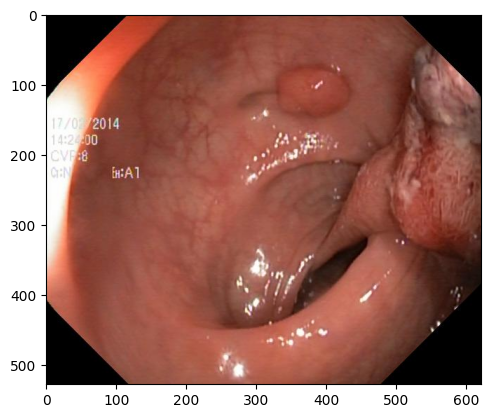

In [50]:
plt.imshow(img_bgr[:,:,::-1])
plt.show()

## Create an empty image

0-background

In [51]:
img_mask = np.zeros(img_bgr.shape[:2])

In [52]:
img_mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

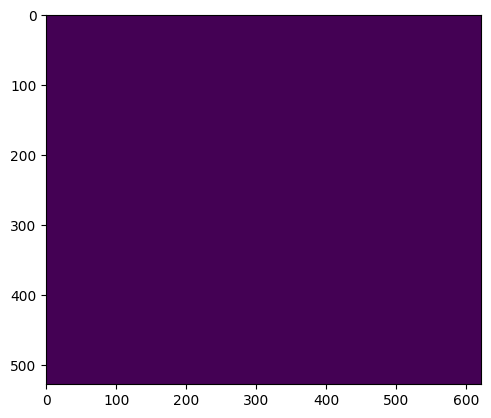

In [53]:
plt.imshow(img_mask)
plt.show()

## Read the json created from labelme

In [54]:
labelme_json_path = '/content/drive/MyDrive/CMIC_hacks/cju0roawvklrq0799vmjorwfv.json'

In [89]:
with open(labelme_json_path, 'r', encoding='utf-8') as f:
    labelme = json.load(f)

AttributeError: ignored

In [56]:
labelme.keys()

dict_keys(['version', 'flags', 'shapes', 'imagePath', 'imageData', 'imageHeight', 'imageWidth'])

## Metadata

In [57]:
labelme['version']

'5.3.1'

In [58]:
# file name of the image
labelme['imagePath']

'cju0roawvklrq0799vmjorwfv.jpg'

In [59]:
# image height
labelme['imageHeight']

528

In [60]:
# image width
labelme['imageWidth']

622

## Print all information about annotation

In [ ]:
# labelme['shapes']

In [61]:
for each in labelme['shapes']:
    print(each['label'], each['shape_type'])

polyp polygon


## Print the information of each class and the order of drawing masks

In [62]:
# 0-background，start with class 1
class_info = [
    {'label':'polyp', 'type':'polygon', 'color':1},     # polygon
]

## Draw the mask on the empty image

In [65]:
for one_class in class_info: # Go through each class in order
    for each in labelme['shapes']: # Go through all annotations to find the annotations that belong to the current class
        if each['label'] == one_class['label']:
            if one_class['type'] == 'polygon': # polygon

                # Get the coordinates
                points = [np.array(each['points'], dtype=np.int32).reshape((-1, 1, 2))]

                # draw mask（closed region）
                img_mask = cv2.fillPoly(img_mask, points, color=one_class['color'])

            elif one_class['type'] == 'line' or one_class['type'] == 'linestrip': # line

                points = [np.array(each['points'], dtype=np.int32).reshape((-1, 1, 2))]

                # draw mask（open region）
                img_mask = cv2.polylines(img_mask, points, isClosed=False, color=one_class['color'], thickness=one_class['thickness'])

            elif one_class['type'] == 'circle': # circle
                points = np.array(each['points'], dtype=np.int32)

                center_x, center_y = points[0][0], points[0][1] # coordinates of center point of the circle

                edge_x, edge_y = points[1][0], points[1][1]

                radius = np.linalg.norm(np.array([center_x, center_y] - np.array([edge_x, edge_y]))).astype('uint32') # radius

                img_mask = cv2.circle(img_mask, (center_x, center_y), radius, one_class['color'], one_class['thickness'])

            else:
                print('unknown class', one_class['type'])

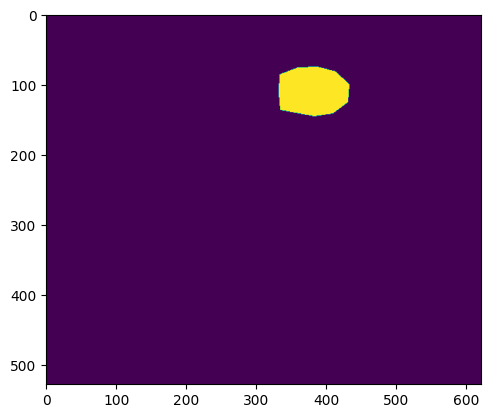

In [66]:
plt.imshow(img_mask)
plt.show()

## Save masks into PNG files

In [67]:
img_mask.shape

(528, 622)

In [68]:
mask_path = img_path.split('.')[0] + '.png'

In [69]:
cv2.imwrite(mask_path, img_mask)

True

## Take a look at saved mask

In [71]:
mask_img = cv2.imread('/content/drive/MyDrive/CMIC_hacks/cju0roawvklrq0799vmjorwfv.png')

In [72]:
mask_img.shape

(528, 622, 3)

In [73]:
np.unique(mask_img)

array([0, 1], dtype=uint8)

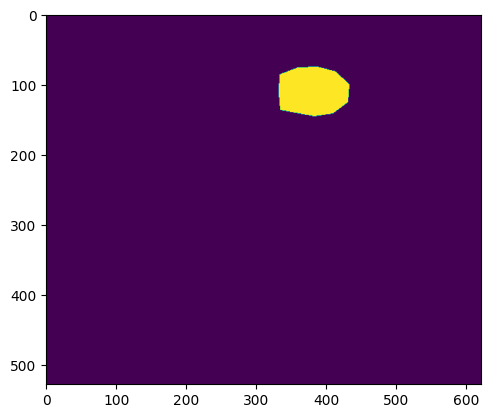

In [74]:
plt.imshow(mask_img[:,:,0])
plt.show()

# Question
<div>
<img src="https://drive.google.com/uc?export=view&id=17F9TTjlpGa5H4BeFzDGd8e0VzWrydtTq" width="400"/>
</div>

In this example, we created the mask for a single image. If we have a collection of images, do you know how to convert them? Give it a try!

In [84]:
import os

folder_path = '/content/drive/MyDrive/CMIC_hacks/'
all_files = os.listdir(folder_path)

# Save separate json and jpg in separate lists
json_files = []
for file in all_files:

  if file.endswith('.json'):
    json_files.append(file)

print(json_files)

json_files[0].split('.')[0]

['cju0s2a9ekvms080138tjjpxr.json', 'cju0roawvklrq0799vmjorwfv.json', 'cju0tl3uz8blh0993wxvn7ly3.json']


'cju0s2a9ekvms080138tjjpxr'

In [93]:
def json_2_mask(json_path):
  """
  Converts json files into png masks using same name
  """
  file_name = json_path.split('.')[0] # obtain only file name
  img_mask = np.zeros(img_bgr.shape[:2]) # Define empty image masks
  with open(json_path, 'r', encoding='utf-8') as f:
    labelme = json.load(f)

    # Convert json file to masks
    # 0-background，start with class 1
    class_info = [
        {'label':'polyp', 'type':'polygon', 'color':1},]     # polygon

    for one_class in class_info:

      for each in labelme['shapes']: # Go through all annotations to find the annotations that belong to the current class
          if each['label'] == one_class['label']:
              if one_class['type'] == 'polygon': # polygon

                  # Get the coordinates
                  points = [np.array(each['points'], dtype=np.int32).reshape((-1, 1, 2))]

                  # draw mask（closed region）
                  img_mask = cv2.fillPoly(img_mask, points, color=one_class['color'])

    # Save masks as png file in same folder
    mask_path = file_name + '.png'
    cv2.imwrite(mask_path, img_mask)


In [95]:
import os

folder_path = '/content/drive/MyDrive/CMIC_hacks/'
all_files = os.listdir(folder_path)

# Save separate json and jpg in separate lists
json_files = []
for file in all_files:

  if file.endswith('.json'):
    json_files.append(file)

print(json_files)

# Convert each json into a mask
for file in json_files:
  print(f"File name : {file}")
  indv_file = os.path.join(folder_path, file)
  json_2_mask(indv_file)


['cju0s2a9ekvms080138tjjpxr.json', 'cju0roawvklrq0799vmjorwfv.json', 'cju0tl3uz8blh0993wxvn7ly3.json']
File name : cju0s2a9ekvms080138tjjpxr.json
File name : cju0roawvklrq0799vmjorwfv.json
File name : cju0tl3uz8blh0993wxvn7ly3.json


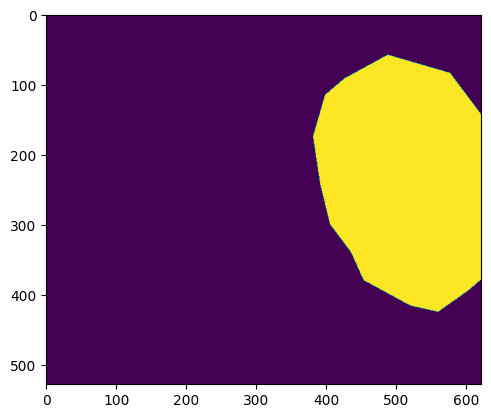

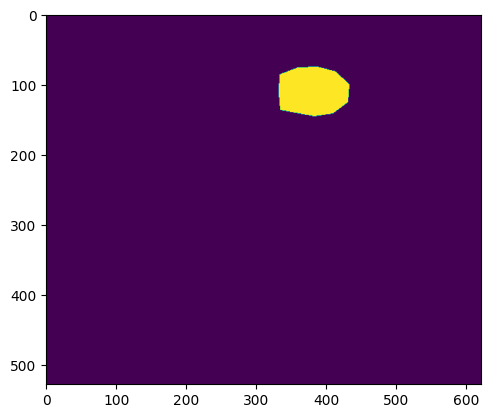

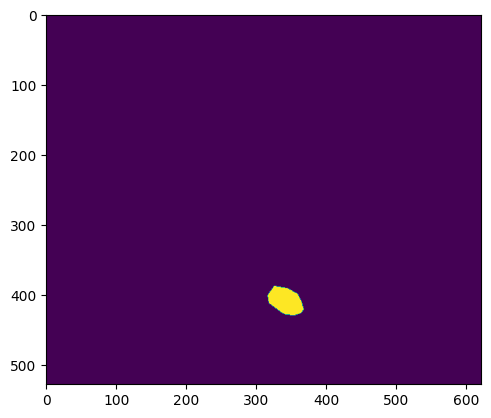

In [98]:
# Check if each saved mask is readible

mask_files = []
all_files = os.listdir(folder_path)

for file in all_files:
  if file.endswith('.png'):
    mask_files.append(file)

mask_files

for file in mask_files:
  # read image
  mask_path = os.path.join(folder_path, file)
  mask_img = cv2.imread(mask_path)

  plt.figure()
  plt.imshow(mask_img[:,:,0])
  plt.show()
